In [90]:
import csv
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from collections import Counter
from sentence_transformers import SentenceTransformer, util
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm

In [2]:
model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-cos-v1')

In [3]:
# Data link: https://www.kaggle.com/datasets/karnikakapoor/video-ads-engagement-dataset?resource=download
campaign_ctr = Counter()
with open("data/Advertising/ad_df.csv") as f:
    reader = csv.DictReader(f)
    for r in reader:
        campaign_ctr[r['campaign_id']] += 1

In [4]:
top_campaigns = {x[0] for x in sorted(campaign_ctr.items(), key=lambda x: -1*x[1])[:100]}

In [5]:
top_campaigns

{'124391',
 '184750',
 '191254',
 '197246',
 '197257',
 '197349',
 '197912',
 '198951',
 '205843',
 '208037',
 '208435',
 '208469',
 '208878',
 '209150',
 '210361',
 '210362',
 '210633',
 '210635',
 '210685',
 '210702',
 '210802',
 '211167',
 '211305',
 '211331',
 '211332',
 '211499',
 '211516',
 '211518',
 '211520',
 '211521',
 '211522',
 '211733',
 '211831',
 '211853',
 '211950',
 '211998',
 '212176',
 '212229',
 '212246',
 '212923',
 '212971',
 '213012',
 '213131',
 '213287',
 '213314',
 '213315',
 '213336',
 '213351',
 '213370',
 '213453',
 '213454',
 '213708',
 '213745',
 '213746',
 '213783',
 '213877',
 '213879',
 '213912',
 '213956',
 '214002',
 '214003',
 '214126',
 '214175',
 '214320',
 '214323',
 '214397',
 '214483',
 '214490',
 '214515',
 '214520',
 '214593',
 '214626',
 '214627',
 '214630',
 '214631',
 '214633',
 '214647',
 '214693',
 '214698',
 '214774',
 '214871',
 '214873',
 '214875',
 '214879',
 '214881',
 '214883',
 '214937',
 '215116',
 '215197',
 '215250',
 '215393',

In [6]:
full_dset = []

In [7]:
rand_prob = .001
gen = np.random.default_rng(seed=0)

In [8]:
with open("data/Advertising/ad_df.csv") as f:
    reader = csv.DictReader(f)
    for r in reader:
        if r['campaign_id'] in top_campaigns and len(r['referer_deep_three']) and gen.random() < rand_prob:
            full_dset.append([r['campaign_id'], r['advertiser_id'], 
                              r['creative_duration'], r['placement_language'],
                              r['referer_deep_three'], r['ua_country'], r['ua_os'], 
                              r['ua_browser'], r['user_average_seconds_played'], r['seconds_played']])

In [9]:
len(full_dset)

2122

In [10]:
# Break out the campaign id, placement_language, ua_country, ua_os, and ua_browser into one-hot encodings, 
# and also get embeddings for the referer_deep_three feature

# Maybe actually encode both the 2nd and 3rd levels
# vocab = set()
# for x in tqdm(full_dset):
#     lvls = x[4].split("/")
#     lvls += [""]*(3-len(lvls))
#     vocab |= {lvls[-2].strip(), lvls[-1].strip()}
# len(vocab)    

In [11]:
# sorted_vocab = sorted(list(vocab))

In [12]:
# len(sorted_vocab)
# pickle.dump(sorted_vocab, open("data/Advertising/sorted_vocab.pkl", 'wb'))

In [13]:
# vocab_embs = []
# chunk = 100
# for idx in tqdm(range(len(vocab)//chunk + 1)):
#     vocab_embs.extend(model.encode(sorted_vocab[idx:min(len(sorted_vocab), idx+chunk)]))

In [10]:
fname = "data/Advertising/vocab_embs.pkl"
# pickle.dump(vocab_embs, open("data/Advertising/vocab_embs.pkl", 'wb'))
vocab_embs = pickle.load(open(fname, 'rb'))
fname = "data/Advertising/sorted_vocab.pkl"
sorted_vocab = pickle.load(open(fname, 'rb'))

In [11]:
vocab_embs[0].shape

(768,)

In [12]:
df = pd.DataFrame(full_dset)

In [13]:
df.columns = ['campaign_id','advertiser_id', 'creative_duration', 'placement_language', 
              'referer_deep_three', 'ua_country', 'ua_os', 'ua_browser', 'user_average_seconds_played', 'seconds_played']

In [68]:
df_dummies = pd.get_dummies(df, columns=['campaign_id','placement_language', 'ua_country', 'ua_os', 'ua_browser'])

In [60]:
embs = np.zeros((len(full_dset), 768*2))
for idx, x in tqdm(enumerate(full_dset)):
    lvls = x[4].split("/")
    lvls += [""]*(3-len(lvls))
    embs[idx, :768] = vocab_embs[sorted_vocab.index(lvls[-2].strip())]
    embs[idx, 768:] = vocab_embs[sorted_vocab.index(lvls[-1].strip())]

0it [00:00, ?it/s]

In [69]:
df_dummies = df_dummies.drop(columns=['referer_deep_three', 'advertiser_id'])

In [71]:
list(df_dummies.columns)

['creative_duration',
 'user_average_seconds_played',
 'seconds_played',
 'campaign_id_124391',
 'campaign_id_184750',
 'campaign_id_191254',
 'campaign_id_197246',
 'campaign_id_197257',
 'campaign_id_197349',
 'campaign_id_197912',
 'campaign_id_198951',
 'campaign_id_205843',
 'campaign_id_208037',
 'campaign_id_208435',
 'campaign_id_208469',
 'campaign_id_208878',
 'campaign_id_209150',
 'campaign_id_210361',
 'campaign_id_210362',
 'campaign_id_210633',
 'campaign_id_210635',
 'campaign_id_210685',
 'campaign_id_210702',
 'campaign_id_210802',
 'campaign_id_211167',
 'campaign_id_211305',
 'campaign_id_211331',
 'campaign_id_211332',
 'campaign_id_211499',
 'campaign_id_211516',
 'campaign_id_211518',
 'campaign_id_211520',
 'campaign_id_211521',
 'campaign_id_211522',
 'campaign_id_211733',
 'campaign_id_211831',
 'campaign_id_211853',
 'campaign_id_211950',
 'campaign_id_211998',
 'campaign_id_212176',
 'campaign_id_212229',
 'campaign_id_212246',
 'campaign_id_212923',
 'campa

In [61]:
embs = pd.DataFrame(embs)

In [19]:
embs[:10]

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,-0.020265,-0.032737,-0.027273,0.085705,-0.034904,0.027943,-0.032076,-0.023835,0.027494,-0.010151,...,-0.039331,-0.034330,-0.024178,-0.011741,-0.016793,0.090289,-0.007154,0.014096,-0.039638,-0.041874
1,0.016959,-0.019917,-0.007092,0.111284,-0.041047,0.000312,-0.013700,-0.009160,0.044137,-0.013007,...,-0.065439,-0.016411,-0.016732,-0.007972,-0.019951,-0.017936,0.010354,-0.034208,-0.022828,-0.063246
2,0.043788,0.053650,0.014296,0.067872,-0.046509,-0.009361,-0.002462,0.015553,0.033761,-0.027542,...,-0.016822,-0.023132,-0.021015,-0.005174,-0.000301,0.061557,0.009487,0.014414,-0.000384,-0.056447
3,0.037962,0.055891,0.007522,-0.011884,0.006016,0.013064,-0.022859,-0.008755,0.095924,-0.006794,...,-0.056287,-0.029346,-0.078982,-0.006681,-0.021423,0.020884,0.022634,-0.023764,0.006762,-0.037375
4,-0.006843,-0.020728,0.013342,0.054791,-0.064110,0.013393,0.058536,-0.006211,0.061000,0.008809,...,-0.046526,-0.041957,-0.009865,-0.001756,-0.003980,0.017570,0.005317,-0.000027,0.030303,-0.074212
5,-0.004803,-0.033287,0.001242,0.096726,-0.036381,-0.008777,0.005429,0.008872,0.015383,0.014411,...,-0.045366,-0.029932,0.036673,0.005916,-0.015758,-0.030245,0.010435,-0.002109,0.037669,-0.034945
6,0.026577,-0.018495,-0.007657,0.104432,-0.011883,0.022969,-0.005357,0.035142,0.032901,0.033493,...,-0.055065,-0.019141,-0.004391,-0.039926,-0.017467,0.004751,-0.009493,0.017066,0.035808,-0.054199
7,0.002281,0.005850,-0.009837,0.100351,-0.009586,-0.036633,-0.022014,-0.030430,0.047507,0.036832,...,-0.055065,-0.019141,-0.004391,-0.039926,-0.017467,0.004751,-0.009493,0.017066,0.035808,-0.054199
8,-0.005258,-0.009517,-0.028858,0.081701,-0.034122,0.007940,0.008639,0.046947,0.076271,0.007385,...,-0.024067,0.005908,-0.026506,-0.018225,-0.018904,-0.008556,-0.033527,0.026027,0.006304,-0.067321
9,0.026577,-0.018495,-0.007657,0.104432,-0.011883,0.022969,-0.005357,0.035142,0.032901,0.033493,...,-0.055065,-0.019141,-0.004391,-0.039926,-0.017467,0.004751,-0.009493,0.017066,0.035808,-0.054199


In [72]:
joined = df_dummies.join(embs)

In [21]:
y = joined['seconds_played']

In [73]:
joined[joined['user_average_seconds_played'] == ''] = 0.0

In [74]:
np.any(joined['user_average_seconds_played'] == '')

False

In [75]:
all_x_cols = joined.columns.tolist()
all_x_cols.remove("seconds_played")

In [76]:
random_idxs = sorted(range(joined.shape[0]), key=lambda x: gen.random())

In [77]:
train_cutoff = int(.8*len(random_idxs))
train_idxs = random_idxs[:train_cutoff]
test_idxs = random_idxs[train_cutoff:]

In [78]:
joined

,creative_duration,user_average_seconds_played,seconds_played,campaign_id_124391,campaign_id_184750,campaign_id_191254,campaign_id_197246,campaign_id_197257,campaign_id_197349,campaign_id_197912,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,30,19.200000762939453,30,0,0,0,0,0,0,0,...,-0.039331,-0.034330,-0.024178,-0.011741,-0.016793,0.090289,-0.007154,0.014096,-0.039638,-0.041874
1,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,69,8.0,1,0,0,0,0,0,0,0,...,-0.056287,-0.029346,-0.078982,-0.006681,-0.021423,0.020884,0.022634,-0.023764,0.006762,-0.037375
4,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2118,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2119,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2120,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [79]:
kernel = DotProduct()
gp = GaussianProcessRegressor(kernel=kernel, alpha=.1)

gp.fit(joined[all_x_cols].iloc[train_idxs], y.iloc[train_idxs])

C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.1, kernel=DotProduct(sigma_0=1))

In [ ]:
# Pick out like 80% as train and 20% as test? 
# Either way, we need to drop the advertiser id and convert referer_deep_three to the embeddings.
# I'm a bit worried that this will be too big to run on the laptop, so probably debug with a smaller set and then
# run the larger training on Swarm or something.


In [49]:
mean_prediction, std_prediction = gp.predict(joined[all_x_cols].iloc[test_idxs], return_std=True)

C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [50]:
mean_prediction

array([ 2.54674390e-11,  5.31499238e+00,  2.54674390e-11,  2.54674390e-11,
        1.09294897e+01,  2.54674390e-11,  2.54674390e-11, -5.40048669e+00,
        2.54674390e-11,  2.54674390e-11,  2.54674390e-11,  2.54674390e-11,
        2.54674390e-11,  2.54674390e-11, -4.23698592e+00,  2.54674390e-11,
        2.54674390e-11,  3.64286275e+00,  2.54674390e-11, -2.68576114e+00,
        7.51802364e+00,  2.54674390e-11,  2.54674390e-11,  2.54674390e-11,
        2.54674390e-11,  2.54674390e-11,  2.54674390e-11,  2.54674390e-11,
        3.51393241e+00,  2.54674390e-11,  2.54674390e-11,  2.54674390e-11,
        1.56488923e+01,  2.54674390e-11,  2.54674390e-11,  2.54674390e-11,
       -9.17110000e+00,  1.48334140e+01,  1.44776565e+01,  2.54674390e-11,
        2.54674390e-11,  1.23652181e+01,  2.54674390e-11,  2.54674390e-11,
        2.54674390e-11,  2.54674390e-11,  2.54674390e-11,  2.54674390e-11,
        2.54674390e-11,  3.70870308e+00,  2.54674390e-11,  2.54674390e-11,
        1.59574957e+01,  

In [52]:
std_prediction

array([9.99999451e-06, 2.30293945e-01, 9.99999451e-06, 9.99999451e-06,
       3.07008339e-01, 9.99999451e-06, 9.99999451e-06, 5.31152374e-01,
       9.99999451e-06, 9.99999451e-06, 9.99999451e-06, 9.99999451e-06,
       9.99999451e-06, 9.99999451e-06, 5.06305998e-01, 9.99999451e-06,
       9.99999451e-06, 2.95500359e-01, 9.99999451e-06, 4.94204920e-01,
       1.61185182e-01, 9.99999451e-06, 9.99999451e-06, 9.99999451e-06,
       9.99999451e-06, 9.99999451e-06, 9.99999451e-06, 9.99999451e-06,
       2.03013579e-01, 9.99999451e-06, 9.99999451e-06, 9.99999451e-06,
       9.51932523e-02, 9.99999451e-06, 9.99999451e-06, 9.99999451e-06,
       3.47524694e-01, 9.00791245e-02, 5.25312352e-01, 9.99999451e-06,
       9.99999451e-06, 8.07433902e-02, 9.99999451e-06, 9.99999451e-06,
       9.99999451e-06, 9.99999451e-06, 9.99999451e-06, 9.99999451e-06,
       9.99999451e-06, 1.84057955e-01, 9.99999451e-06, 9.99999451e-06,
       1.67845345e-01, 9.99999451e-06, 9.99999451e-06, 8.54344863e-01,
      

In [80]:
y.iloc[test_idxs]

956      26
1242      2
814      12
1916    0.0
1313    0.0
       ... 
652     0.0
516     0.0
415       1
862     0.0
1018    0.0
Name: seconds_played, Length: 425, dtype: object

In [81]:
# Cross the test users with the campaigns and predict the mean and standard deviation for how long they'll watch
# Create a numpy array that holds the means, and one that holds the std devs

mus = np.zeros((len(top_campaigns), len(test_idxs)))
sigs = np.zeros((len(top_campaigns), len(test_idxs)))
print(mus.shape)

(100, 425)


In [82]:
test_joined = joined.iloc[test_idxs]

In [83]:
test_joined

,creative_duration,user_average_seconds_played,seconds_played,campaign_id_124391,campaign_id_184750,campaign_id_191254,campaign_id_197246,campaign_id_197257,campaign_id_197349,campaign_id_197912,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
956,29,3.5416667461395264,26,0,0,0,0,0,0,0,...,0.008917,-0.012930,0.019555,-0.012958,-0.019570,-0.030035,0.013783,-0.002655,0.003338,-0.025784
1242,14,10.433281898498535,2,0,0,0,0,0,0,0,...,-0.018354,0.005895,-0.002002,-0.011352,-0.007720,0.108042,-0.002446,-0.015852,-0.013928,-0.048614
814,69,14.0,12,0,0,0,0,0,0,0,...,-0.012511,0.006991,-0.009321,0.013864,-0.019425,-0.025975,0.008178,0.003105,-0.047728,-0.017259
1916,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1313,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
516,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
415,29,7.666666507720947,1,0,0,0,0,0,0,0,...,0.021388,-0.014516,0.045246,0.004600,-0.027450,-0.054890,0.009458,-0.010986,-0.030796,-0.021520
862,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [88]:
for idx, campaign in tqdm(enumerate(top_campaigns)):
    # Replace all campaigns in the test dataframe with this campaign, and predict the rows of the mean and std matrices
    for cid in top_campaigns:
        test_joined['campaign_id_%s' % cid] = 0
    test_joined['campaign_id_%s' % campaign] = 1
    mean_prediction, std_prediction = gp.predict(test_joined[all_x_cols], return_std=True)
    mus[idx] = mean_prediction
    sigs[idx] = std_prediction

0it [00:00, ?it/s]

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_7692\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['in

<Axes: ylabel='Count'>

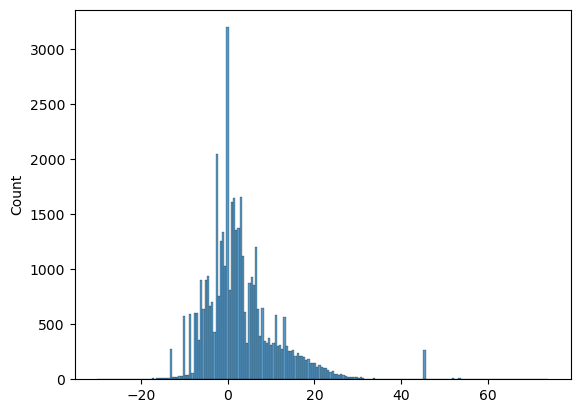

In [91]:
sns.histplot(mus.flatten())

<Axes: ylabel='Count'>

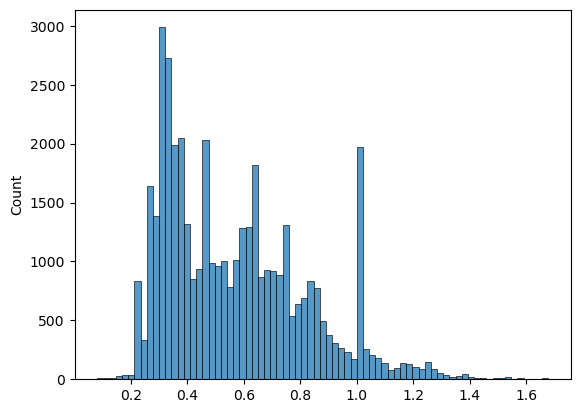

In [92]:
sns.histplot(sigs.flatten())

In [ ]:
# Use CV to get error bounds for adversarial robustness